| Column Name                          | Description                                                                 |
|--------------------------------------|-----------------------------------------------------------------------------|
| **Date**                             | Date of the booking                                                         |
| **Time**                             | Time of the booking                                                         |
| **Booking ID**                       | Unique identifier for each ride booking                                     |
| **Booking Status**                   | Status of booking (Completed, Cancelled by Customer, Cancelled by Driver, etc.) |
| **Customer ID**                      | Unique identifier for customers                                             |
| **Vehicle Type**                     | Type of vehicle (Go Mini, Go Sedan, Auto, eBike/Bike, UberXL, Premier Sedan)|
| **Pickup Location**                  | Starting location of the ride                                               |
| **Drop Location**                    | Destination location of the ride                                            |
| **Avg VTAT**                         | Average time for driver to reach pickup location (in minutes)               |
| **Avg CTAT**                         | Average trip duration from pickup to destination (in minutes)               |
| **Cancelled Rides by Customer (TARGET)** | Customer-initiated cancellation flag                                    |
| **Reason for cancelling by Customer**| Reason for customer cancellation                                            |
| **Cancelled Rides by Driver**        | Driver-initiated cancellation flag                                          |
| **Driver Cancellation Reason**       | Reason for driver cancellation                                              |
| **Incomplete Rides**                 | Incomplete ride flag                                                        |
| **Incomplete Rides Reason**          | Reason for incomplete rides                                                 |
| **Booking Value**                    | Total fare amount for the ride                                              |
| **Ride Distance**                    | Distance covered during the ride (in km)                                    |
| **Driver Ratings**                   | Rating given to driver (1-5 scale)                                          |
| **Customer Rating**                  | Rating given by customer (1-5 scale)                                        |
| **Payment Method**                   | Method used for payment (UPI, Cash, Credit Card, Uber Wallet, Debit Card)   |


## Main Objective

The primary objective of this project is to develop a **predictive model** capable of accurately forecasting **customer cancellations** of Uber based on a diverse set of predictors.  

Achieving this requires:  
- Extensive data preprocessing 
- Feature engineering and preparation  
- Handling challenges such as:  
  - Missing values  
  - Encoding of categorical variables  
  - Class imbalance  

By refining the dataset and applying appropriate machine learning techniques, the model aims to:  
- Provide actionable insights  
- Enable proactive intervention strategies  
- Ultimately improve customer retention

In [83]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor , XGBClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [84]:
df = pd.read_csv('ncr_ride_bookings (1).csv')

In [85]:
df.shape

(150000, 21)

In [86]:
df.head(2)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI


In [87]:
print(df.info())

print(df.describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

 # EDA

Text(0, 0.5, '')

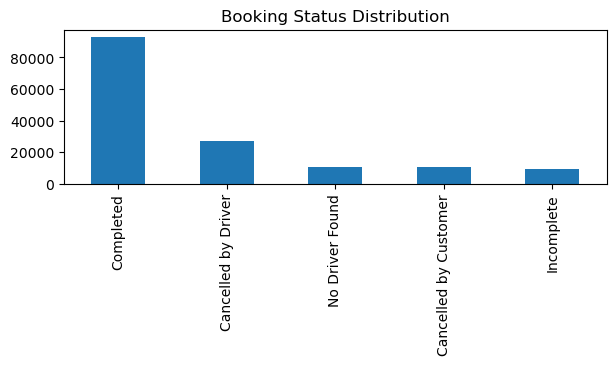

In [88]:
status_counts = df['Booking Status'].value_counts()
status_counts.plot(kind='bar', figsize=(7,2), title="Booking Status Distribution")
plt.xlabel("")
plt.ylabel("")

#### The majority of rides were completed , with rides cancelled by Driver being second in order. 

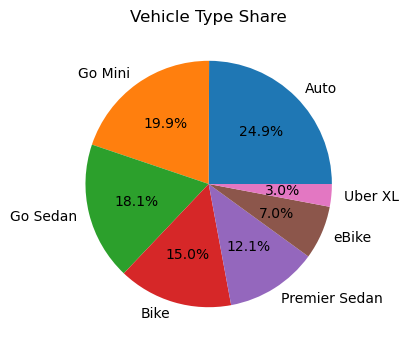

In [89]:
vehicle_counts = df['Vehicle Type'].value_counts()
vehicle_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(4,4), title="Vehicle Type Share")
plt.xlabel("")  
plt.ylabel("")  
plt.show()

#### Looking at the overall picture, the pie chart indicates that the majority of customers strongly prefer 4-wheel vehicles over 2- or 3-wheel options. This makes sense, as regular cars typically offer greater comfort and convenience.

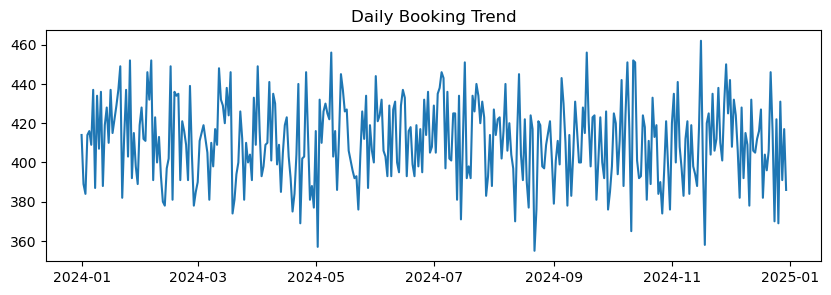

In [90]:
df['Date'] = pd.to_datetime(df['Date'])
daily_trend = df.groupby(df['Date'].dt.date)['Booking ID'].count()

daily_trend.plot(figsize=(10,3), title="Daily Booking Trend")
plt.xlabel("")  
plt.ylabel("")
plt.show()

#### Trend Analysis indicates deep seasonality through daily time periods complemented by some severe spikes which might refer, for instance, to strikes or festivals.

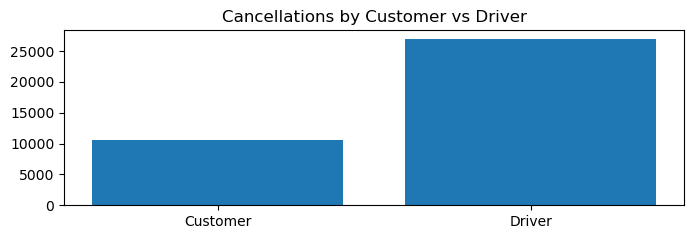

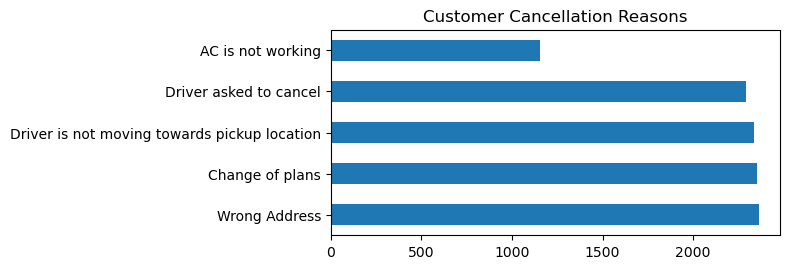

In [91]:
plt.figure(figsize=(8,5))

plt.subplot(2,1,1)
cancel_by_customer = df['Cancelled Rides by Customer'].sum()
cancel_by_driver = df['Cancelled Rides by Driver'].sum()

plt.bar(['Customer', 'Driver'], [cancel_by_customer, cancel_by_driver])
plt.title("Cancellations by Customer vs Driver")
plt.xlabel("")  
plt.ylabel("")
plt.show()

plt.subplot(2,1,2)
cancel_reasons = df['Reason for cancelling by Customer'].value_counts()

cancel_reasons.plot(kind='barh', figsize=(8,5), title="Customer Cancellation Reasons")
plt.xlabel("")  
plt.ylabel("")

plt.tight_layout()
plt.show()

#### Most driver cancellations typically happen due to factors such as long distances or less desirable locations. On the other hand, customer cancellation reasons appear to be fairly balanced across different factors, with the exception of "AC not working," which does not seem to reflect a major source of dissatisfaction.

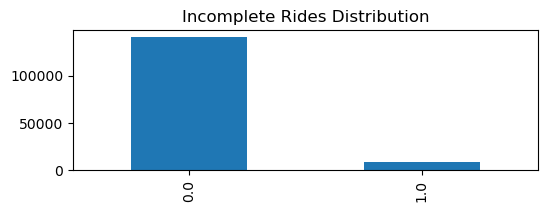

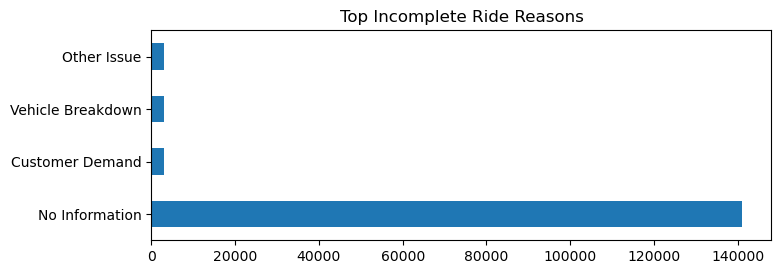

In [92]:
df['Incomplete Rides'].fillna(0,inplace=True)
incomplete_counts = df['Incomplete Rides'].value_counts()

plt.subplot(2,1,1)
incomplete_counts.plot(kind='bar', figsize=(6,4), title="Incomplete Rides Distribution")
plt.xlabel("")  
plt.ylabel("")
plt.show()

plt.subplot(2,1,2)
df['Incomplete Rides Reason'].fillna('No Information' , inplace=True)
reasons = df['Incomplete Rides Reason'].value_counts().head(10)
reasons.plot(kind='barh', title="Top Incomplete Ride Reasons", figsize=(8,6))
plt.xlabel("")  
plt.ylabel("")
plt.show()

#### One can notice that most of rides were completed as we saw above at Booking Status Distribution , while we don't have enough information at our disposal in order to reflect the problem to specific factors.

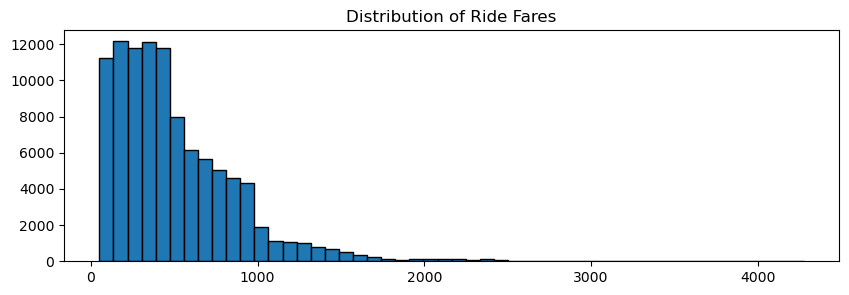

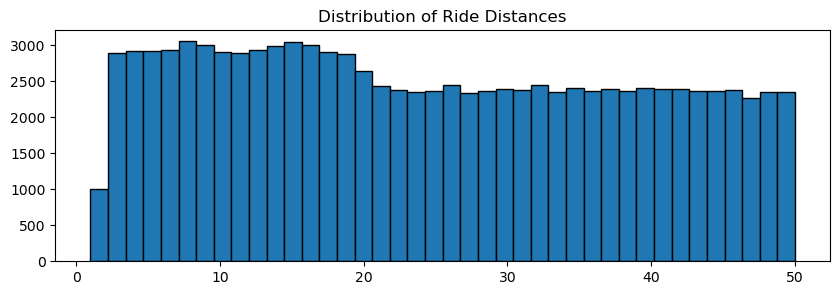

In [93]:
plt.figure(figsize=(10,3))
plt.hist(df['Booking Value'], bins=50, edgecolor='black')
plt.title("Distribution of Ride Fares")
plt.show()

plt.figure(figsize=(10,3))
plt.hist(df['Ride Distance'], bins=40, edgecolor='black')
plt.title("Distribution of Ride Distances")
plt.show()

#### Ride distances are balanced with Booking Values being right-skewed which may suggest rides being integrated by vast distances and big or luxurious cars.

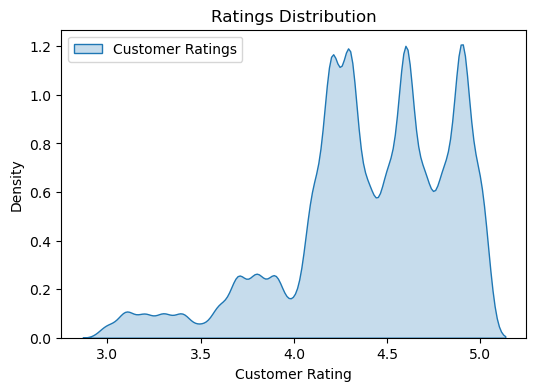

In [94]:
plt.figure(figsize=(6,4))
sns.kdeplot(df['Customer Rating'], label="Customer Ratings", shade=True)
plt.title("Ratings Distribution")
plt.legend()
plt.show()

#### Overall, customer rating majority is above 4.0, indicating a high level satisfaction and a smooth total experience.

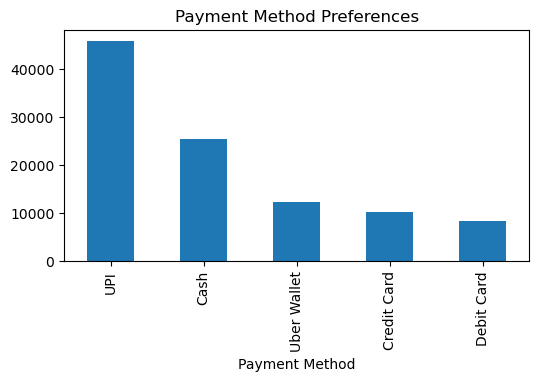

In [95]:
payment_counts = df['Payment Method'].value_counts()
payment_counts.plot(kind='bar', figsize=(6,3), title="Payment Method Preferences")
plt.show()

#### The plural of payments were configured by UPI which refers to an instant payment system using a smartphone app. While thriving at second place , Cash still retains it's significance within payment types.

#### First things first, we will drop the columns which may introduce data leakage to our target variable. Furthermore, we will wipe out features which are insignificant.

In [96]:
df.drop(['Booking ID','Booking Status','Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason'], axis =1 , inplace=True)

In [97]:
df.head(2)

,Date,Time,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,237.0,5.73,NaN,NaN,UPI


### Take care of Datetime

In [98]:
# First convert Date and Time with datetime function of pandas and then combine them as datetime 
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce').dt.time

df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str),
                                errors='coerce')

# Extract components from datetime, like hour , day etc. 
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.dayofweek  # Careful -> Monday=0, Sunday=6
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

In [99]:
df[['Time','datetime','hour', 'day', 'month', 'weekday', 'is_weekend']].head()

,Time,datetime,hour,day,month,weekday,is_weekend
0,12:29:38,2024-03-23 12:29:38,12,23,3,5,1
1,18:01:39,2024-11-29 18:01:39,18,29,11,4,0
2,08:56:10,2024-08-23 08:56:10,8,23,8,4,0
3,17:17:25,2024-10-21 17:17:25,17,21,10,0,0
4,22:08:00,2024-09-16 22:08:00,22,16,9,0,0


### Feature Engineering

In [100]:
df = df.rename(columns={
    "Cancelled Rides by Customer": "target_cancellation"
})

In [101]:
df['target_cancellation'].fillna(0 , inplace=True)

In [102]:
df['target_cancellation'] = df['target_cancellation'].astype(int)

In [103]:
# Sort by customer and datetime
df = df.sort_values(by=['Customer ID', 'datetime'])

# Calculate time since last booking (in days)
df['time_since_last_booking'] = (df.groupby('Customer ID')['datetime'].diff().dt.total_seconds() / (3600*24)).round(0)

# Fill NaN for first booking with median or 0
df['time_since_last_booking'].fillna(df['time_since_last_booking'].median(), inplace=True)

In [104]:
# Customer total bookings
cust_count = df['Customer ID'].value_counts().to_dict()
df['customer_total_bookings'] = df['Customer ID'].map(cust_count)

In [105]:
# Pickup frequency encoding
pickup_freq = df['Pickup Location'].value_counts().to_dict()
df['pickup_freq'] = df['Pickup Location'].map(pickup_freq)

# Drop frequency encoding
drop_freq = df['Drop Location'].value_counts().to_dict()
df['drop_freq'] = df['Drop Location'].map(drop_freq)

In [106]:
df['Vehicle Type'].unique()

array(['Bike', 'Auto', 'Go Sedan', 'Go Mini', 'eBike', 'Premier Sedan',
       'Uber XL'], dtype=object)

In [107]:
# Define the mapping
categories = {
    'Bike': '2 & 3-Wheel Rides',
    'eBike': '2 & 3-Wheel Rides',
    'Auto': '2 & 3-Wheel Rides',
    'Go Sedan': '4-Wheel Rides',
    'Premier Sedan': '4-Wheel Rides',
    'Go Mini': '4-Wheel Rides',
    'Uber XL': '4-Wheel Rides'
}

# Mitigate granularity by applying mapping
df['Vehicle Type'] = df['Vehicle Type'].map(categories)

In [108]:
df['Payment Method'].unique()

array(['Cash', nan, 'Uber Wallet', 'UPI', 'Debit Card', 'Credit Card'],
      dtype=object)

#### Also mitigate the granularity with grouping

In [109]:
# Define the mapping
payment_groups = {
    'UPI': 'Digital Wallets',
    'Uber Wallet': 'Digital Wallets',
    'Debit Card': 'Cards',
    'Credit Card': 'Cards',
    'Cash': 'Cash'
}

# Mitigate granularity by applying mapping
df['Payment Method'] = df['Payment Method'].map(payment_groups)

In [110]:
df.columns

Index(['Date', 'Time', 'Customer ID', 'Vehicle Type', 'Pickup Location',
       'Drop Location', 'Avg VTAT', 'Avg CTAT', 'target_cancellation',
       'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating',
       'Payment Method', 'datetime', 'hour', 'day', 'month', 'weekday',
       'is_weekend', 'time_since_last_booking', 'customer_total_bookings',
       'pickup_freq', 'drop_freq'],
      dtype='object')

In [111]:
# Drop unnecessary columns
df.drop(['Date', 'Time','datetime', 'Customer ID', 'Pickup Location', 'Drop Location',] , axis=1 , inplace=True)

In [112]:
df.head(3)

,Vehicle Type,Avg VTAT,Avg CTAT,target_cancellation,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,hour,day,month,weekday,is_weekend,time_since_last_booking,customer_total_bookings,pickup_freq,drop_freq
79865,2 & 3-Wheel Rides,6.9,20.5,0,634.0,16.04,NaN,NaN,Cash,20,18,3,0,0,113.5,1,845,859
15005,2 & 3-Wheel Rides,5.6,NaN,0,NaN,NaN,NaN,NaN,NaN,17,5,7,4,0,113.5,1,827,842
148537,4-Wheel Rides,6.2,31.6,0,458.0,13.32,4.2,4.3,Cash,12,26,9,3,0,113.5,1,800,877


 ## Encoding Categorical Features

In [113]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
# Summary dataframe with distinct classes and counts
summary = {
    "feature": [],
    "n_distinct_classes": []
}

for col in categorical_cols:
    unique_classes = df[col].unique().tolist()
    summary["feature"].append(col)
    summary["n_distinct_classes"].append(len(unique_classes))

summary_df = pd.DataFrame(summary)

summary_df

,feature,n_distinct_classes
0,Vehicle Type,2
1,Payment Method,4


#### Since both categorical variables is considered to have low cardinality, it can be encoded with simple one-hot method.

In [114]:
df = pd.get_dummies(df , drop_first=True , dtype=int)

In [115]:
df.head(2)

,Avg VTAT,Avg CTAT,target_cancellation,Booking Value,Ride Distance,Driver Ratings,Customer Rating,hour,day,month,weekday,is_weekend,time_since_last_booking,customer_total_bookings,pickup_freq,drop_freq,Vehicle Type_4-Wheel Rides,Payment Method_Cash,Payment Method_Digital Wallets
79865,6.9,20.5,0,634.0,16.04,NaN,NaN,20,18,3,0,0,113.5,1,845,859,0,1,0
15005,5.6,NaN,0,NaN,NaN,NaN,NaN,17,5,7,4,0,113.5,1,827,842,0,0,0


In [116]:
df.shape

(150000, 19)

## Handling Outliers / Extreme Values

<Axes: xlabel='Booking Value', ylabel='Count'>

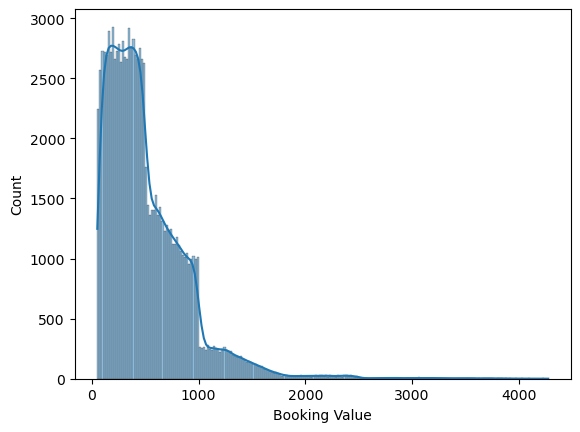

In [117]:
sns.histplot(data = df , x='Booking Value' , kde=True)

#### This feauture signifies a severe right skewness which can be considered as extreme values / outliers. An elbow point is visible around 1300 units.
#### This indicate passengers that are willing to pay a high amount of money and so this uber ride is a major necessity for them. Ultimately , we can conclude that the cancellation frequency on this hypothesis is critical since it judges a big amount of revenue.

In [118]:
print("The percentage of outliers to overall dataset is: " ,
round((df[df['Booking Value'] > 1300].shape[0]/150000) *100 ,2) )

The percentage of outliers to overall dataset is:  2.76


#### Since we need to impute the above feature later on , we should impute in the original scale first, then log-transform afterward for modeling.

## Missing Values Handling

In [119]:
# Initiate a dataframe which contains Columns and their missing percentage respectfully
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0]
print(missing_percent)

Avg VTAT            7.0
Avg CTAT           32.0
Booking Value      32.0
Ride Distance      32.0
Driver Ratings     38.0
Customer Rating    38.0
dtype: float64


### Avg VTAT and Avg CTAT

<Axes: xlabel='Avg VTAT', ylabel='Count'>

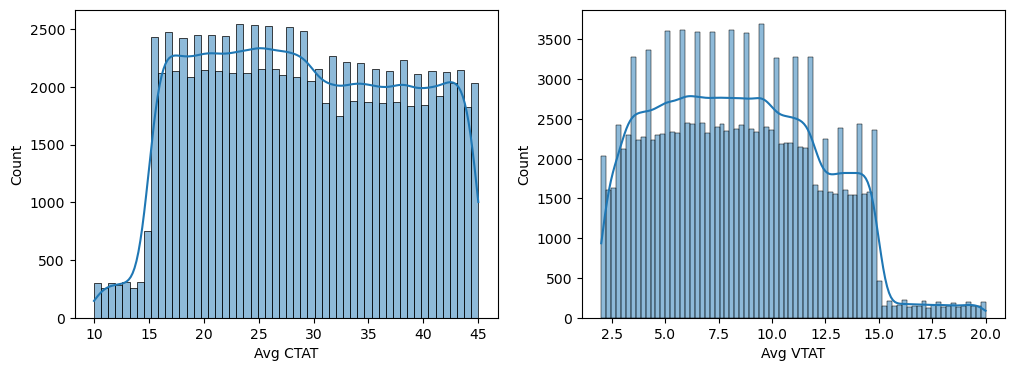

In [120]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data = df , x='Avg CTAT' , kde=True)

plt.subplot(1,2,2)
sns.histplot(data = df , x='Avg VTAT' , kde=True)

#### Median is preferred, due to its robustness to outliers , preservation of distribution shape and stableness for spikes

In [121]:
imputer = SimpleImputer(strategy='median')
df[['Avg VTAT']] = imputer.fit_transform(df[['Avg VTAT']])
df[['Avg CTAT']] = imputer.fit_transform(df[['Avg CTAT']])

### Target variable

### Rest of features
#### These attributes require special treatment since they contain 30% - 40% of null values. Thus, a reliable way is to settle machine learning models.
#### This option refers to features with missingness as targets and the others as predictors.

Note : XGBoost will be our case due to usage of trees, very good overall performance and it's rapidness.

#### Since we need to encounter the missingness with 4 different regression models, a rational approach would be to construct a general function 

In [122]:
def impute_with_xgboost_regressor(df , target_col , n_iter=10 , cv=4):
    """ 
    Impute missing values for a numeric feature with XGBoost and RandomizedSearchCV
    to mitigate computational time

    Parameters:
    - df : Dataframe ( df_encoded )
    - target_col : column to impute
    - n_iter : 20 iterations across combinations
    - cv : 4 folds for tuning

    Returns:
    - df_imputed with imputed values ( df_imputed )
    - best_model Trained XGBRegressor model
    """

    # Split data into non-null and null
    df_train = df[df[target_col].notnull()].copy()
    df_test = df[df[target_col].isnull()].copy()

    # We will manipulate only train set in this case to test the performance of our model
    # before imputing the predictions
    X = df_train.drop(columns=[target_col])
    y = df_train[target_col]

    # Train / Validation split
    x_train , x_val , y_train , y_val = train_test_split(X, y , test_size=0.2 ,
                                                         random_state= 100)

    # Initialize model 
    model = XGBRegressor( random_state = 100 , n_jobs=-1 , objective='reg:squarederror')

    # Parameter grid 
    param_grid = {
        "n_estimators": [100, 200, 300, 500,700],
        "max_depth": [3, 5, 7, 10 ,12],
        "learning_rate": [0.001 , 0.01, 0.05, 0.1, 0.2],
        "subsample": [0.2 , 0.4 , 0.6, 0.8, 1.0],
        "colsample_bytree": [0.2, 0.4, 0.6, 0.8, 1.0],
        "gamma": [0, 0.1, 0.2, 0.5],
    }
    
    search = RandomizedSearchCV(model , param_distributions= param_grid, n_iter = n_iter, cv=cv, scoring = 'neg_mean_squared_error',verbose=1,random_state = 100 ,n_jobs=-1)

    search.fit(x_train,y_train)

    best_model = search.best_estimator_

    # Validate performance
    y_pred = best_model.predict(x_val)
    val_rmse = root_mean_squared_error(y_val , y_pred) 
    print('Validation RMSE : ' ,val_rmse)
    print('Best Parameters : ' , search.best_params_)

    # Impute missing values 
    if not df_test.empty:
      X_test = df_test.drop(columns=[target_col])
      df.loc[df[target_col].isnull(), target_col] = best_model.predict(X_test)

    
    return df , best_model

 ### Customer Ratings

In [123]:
df_imputed, best_model = impute_with_xgboost_regressor(df, target_col="Customer Rating")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Validation RMSE :  0.43639227166971595
Best Parameters :  {'subsample': 0.2, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.001, 'gamma': 0.1, 'colsample_bytree': 0.6}


### Driver Ratings

In [124]:
df_imputed, best_model = impute_with_xgboost_regressor(df_imputed, target_col="Driver Ratings")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Validation RMSE :  0.4344072710647623
Best Parameters :  {'subsample': 0.4, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.001, 'gamma': 0.5, 'colsample_bytree': 0.6}


 ### Ride Distance

In [125]:
df_imputed, best_model = impute_with_xgboost_regressor(df_imputed, target_col="Ride Distance")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Validation RMSE :  13.456688675700573
Best Parameters :  {'subsample': 1.0, 'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.4}


### Booking Value

In [126]:
df_imputed, best_model = impute_with_xgboost_regressor(df_imputed, target_col="Booking Value")

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Validation RMSE :  387.9748449530002
Best Parameters :  {'subsample': 1.0, 'n_estimators': 700, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.4}


In [127]:
print('The Mean values of imputed features are : ')
df_imputed[['Customer Rating' , 'Driver Ratings' ,'Ride Distance','Booking Value' ]].describe().loc['mean']

The Mean values of imputed features are : 


Customer Rating      4.405997
Driver Ratings       4.230560
Ride Distance       21.195570
Booking Value      599.103899
Name: mean, dtype: float64

### Summary
#### Conclusions about first three consist of low validation RMSE, reflecting to what they represent and to their mean values, which signifies that our model performs very well, thus the predictions for the null values will be relatively precise.
#### The RMSE for 'Booking Value' seems large, yet relative to its mean value, it remains low.

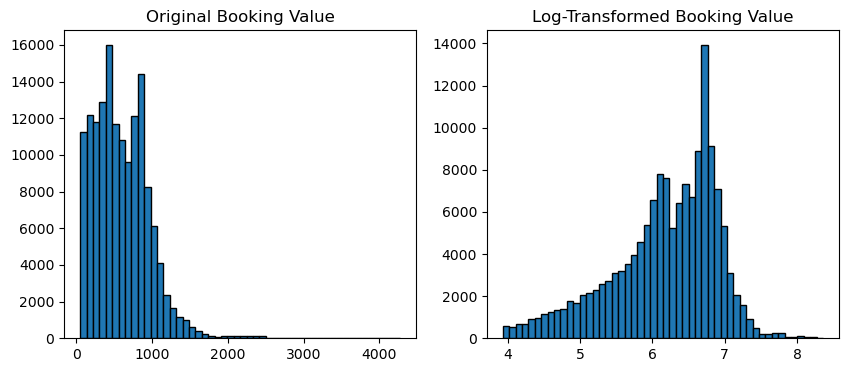

In [128]:
# Apply log transformation (add 1 to avoid log(0))
df_imputed['Booking_Value_log'] = np.log1p(df_imputed['Booking Value'])

# Compare distributions
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df_imputed['Booking Value'], bins=50, edgecolor='black')
plt.title("Original Booking Value")

plt.subplot(1,2,2)
plt.hist(df_imputed['Booking_Value_log'], bins=50, edgecolor='black')
plt.title("Log-Transformed Booking Value")
plt.show()

In [129]:
df_imputed.head(2)

,Avg VTAT,Avg CTAT,target_cancellation,Booking Value,Ride Distance,Driver Ratings,Customer Rating,hour,day,month,weekday,is_weekend,time_since_last_booking,customer_total_bookings,pickup_freq,drop_freq,Vehicle Type_4-Wheel Rides,Payment Method_Cash,Payment Method_Digital Wallets,Booking_Value_log
79865,6.9,20.5,0,634.000000,16.040000,4.231519,4.404966,20,18,3,0,0,113.5,1,845,859,0,1,0,6.453625
15005,5.6,28.8,0,1218.511353,15.454856,4.234414,4.409519,17,5,7,4,0,113.5,1,827,842,0,0,0,7.106206


 ## Cancellation Prediction modeling

## XGBoost

In [130]:
df_imputed['target_cancellation'].value_counts()

target_cancellation
0    139500
1     10500
Name: count, dtype: int64

In [131]:
# First split target feature and predictors
df_imputed['target_cancellation'] = df_imputed['target_cancellation'].astype(int)

X = df_imputed.drop(columns=['target_cancellation'])
y = df_imputed['target_cancellation']

In [132]:
# Train-test split 
x_train, x_test, y_train, y_test = train_test_split(X , y , stratify= y,
                                                    test_size=0.33 , random_state=100) 

In [133]:
from collections import Counter

counter = Counter(y_train)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 13.285714285714286


#### As we noticed at the beginning our target variable consists of imabalanced classes. A rational solution is to find the weights of each class and incorporate them into models. Since, we are using XGBoost, we should examine scale_pos_weight which is the ratio of number of negative class to positive class.

In [134]:
# We are going to use RandomizedSearch due to large number of parameter combinations

# Define a parameter grid 
param_grid = {
    "n_estimators": [100, 200, 300, 500, 700],
    "max_depth": [3, 5, 7, 10, 12, 15, 20, 25],
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    "subsample": [0.2, 0.4, 0.6, 0.8, 1.0],
    "colsample_bytree": [0.2, 0.4, 0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_lambda": [0.001, 0.01, 0.1, 1, 10, 50, 100],  # L2 regularization
    "reg_alpha": [0,0.001, 0.01, 0.1, 1, 5, 10],      # L1 regularization
}

model = XGBClassifier(objective='binary:logistic',scale_pos_weight=13.29, 
                      eval_metric="auc" , n_jobs=-1)

rs = RandomizedSearchCV(model , param_distributions= param_grid, n_iter=30 ,
                        scoring= 'roc_auc',
                        cv= 3 , n_jobs=-1 ,verbose=2, random_state=100)



rs.fit(x_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrai...
                   param_distributions={'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.5],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2, 0.3, 0.5],
                                        'max_depth': [3, 5, 7, 10, 12, 15, 20,
                                                      25],
                                        'n_estimators': [100, 200, 300, 500,
                                                         700],
                                        'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 5,
                                                      10],
                                        'reg_lambda': [0.001, 0.01, 0.1, 1, 10,
                                                       50, 100],
                                        'subsample': [0.2, 0.4, 0.6, 0.8, 1.0]},
                   random_state=100, scoring='roc_auc', verbose=2)

In [135]:
# Extract the tuned model and predict
tuned_model = rs.best_estimator_
y_pred = tuned_model.predict(x_test)
y_pred_proba = tuned_model.predict_proba(x_test)[:,1]

In [136]:
# Evaluate numerically
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

[[39338  6697]
 [   37  3428]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     46035
           1       0.34      0.99      0.50      3465

    accuracy                           0.86     49500
   macro avg       0.67      0.92      0.71     49500
weighted avg       0.95      0.86      0.89     49500

ROC AUC: 0.9646527369303517


Metrics per class:

---Class 0 (majority):

- Precision = 1.00 (very few false positives relative to TN+FN)

- Recall = 0.85 (some Class 0 predicted as Class 1)

- F1-score = 0.92 (strong overall performance)

---Class 1 (minority):

- Precision = 0.34 (many false positives → low precision)

- Recall = 0.99 (almost all positives detected → very high sensitivity)

- F1-score = 0.50 (tradeoff between low precision and high recall)


Overall performance:

- Accuracy = 0.86 (but influenced by class imbalance).

- Macro avg F1 = 0.71 (treats both classes equally → shows weakness on Class 1).

- Weighted avg F1 = 0.89 (skewed by majority class performance).

- ROC AUC = 0.9646 → excellent ranking ability overall.


Key Insights:

- High recall for Class 1 (0.99): The model catches almost all true positives. This is good if missing positives is very costly (e.g., fraud detection, medical diagnosis).

- Low precision for Class 1 (0.34): Many false alarms (positives predicted incorrectly). This could lead to unnecessary interventions.

- Imbalance impact: Class 0 dominates → accuracy looks good (0.86), but performance on Class 1 is much weaker.

- Tradeoff visible: The model is tuned toward recall (sensitivity) at the cost of precision. Depending on the use case, this may or may not be acceptable.


✅ Summary:
The model is excellent at detecting positives (high recall, high ROC AUC), but struggles with precision (lots of false positives). If we intend to amend that , we may need to tune the decision threshold, use precision-recall tradeoff techniques, or rebalance training data.

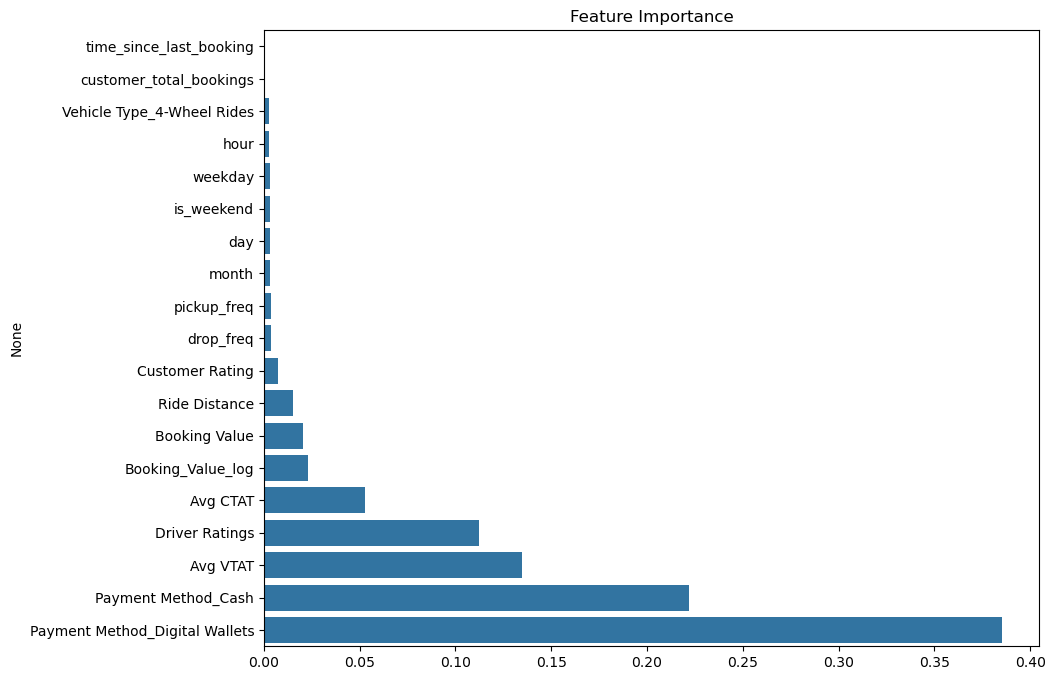

In [137]:
feature_importances = tuned_model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

#### Most significant features of XGBoost for cancellations by customers  appear to be both payments methods of Cash and Digital Wallet, Ride Distance , Avg CTAT, Avg VTAT, and maybe Driver Ratings and weekday.

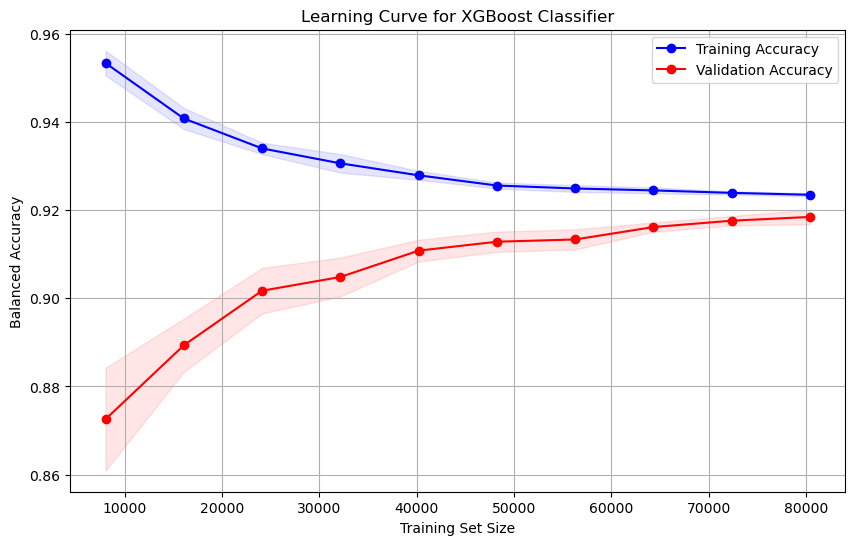

In [138]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    tuned_model, 
    x_train, 
    y_train, 
    cv=5, 
    scoring='balanced_accuracy',   # Imbalanced classes
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=100
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.title('Learning Curve for XGBoost Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Balanced Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

#### Learning curve gives us insights about the overfitting factor of the model. As we observe, graph initiates with an overfit, due to a vast gap between training and validation lines. As we increment the training size, both lines tend to getting close to each other diminishing the factor of overfitting until they stabilize to a point where a slight overfitting occurs.

## LightGBM

In [139]:
gbm_grid = {
    "num_leaves": [15, 31, 63, 127],        # complexity of trees
    "max_depth": [-1, 5, 10, 20],           # -1 = no limit
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
    "n_estimators": [200, 500, 1000],
    "min_child_samples": [10, 20, 50, 100], # min data in leaf
    "subsample": [0.6, 0.8, 1.0],           # row sampling
    "colsample_bytree": [0.6, 0.8, 1.0],    # feature sampling
    "reg_alpha": [0, 0.1, 1, 10],           # L1 regularization
    "reg_lambda": [0, 0.1, 1, 10],          # L2 regularization
}


lgbm = lgb.LGBMClassifier(
    objective="binary",
    is_unbalance=True,  # handle imbalance
    random_state=42,
    n_jobs=-1)
rs = RandomizedSearchCV(lgbm , param_distributions= gbm_grid, n_iter=30 ,
                        scoring= 'roc_auc',
                        cv= 3 , n_jobs=-1 ,verbose=2, random_state=100)



rs.fit(x_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7035, number of negative: 93465
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2196
[LightGBM] [Info] Number of data points in the train set: 100500, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070000 -> initscore=-2.586689
[LightGBM] [Info] Start training from score -2.586689


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True, n_jobs=-1,
                                            objective='binary',
                                            random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1, 0.2],
                                        'max_depth': [-1, 5, 10, 20],
                                        'min_child_samples': [10, 20, 50, 100],
                                        'n_estimators': [200, 500, 1000],
                                        'num_leaves': [15, 31, 63, 127],
                                        'reg_alpha': [0, 0.1, 1, 10],
                                        'reg_lambda': [0, 0.1, 1, 10],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=100, scoring='roc_auc', verbose=2)

In [140]:
# Extract the tuned model and predict
tuned_model_lgb = rs.best_estimator_
y_pred_lgb = tuned_model_lgb.predict(x_test)
y_pred_proba_lgb = tuned_model_lgb.predict_proba(x_test)[:,1]

In [141]:
# Evaluate numerically
print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_lgb))

[[39240  6795]
 [   21  3444]]
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     46035
           1       0.34      0.99      0.50      3465

    accuracy                           0.86     49500
   macro avg       0.67      0.92      0.71     49500
weighted avg       0.95      0.86      0.89     49500

ROC AUC: 0.9646474927869518


Metrics per class:

---Class 0 (majority):

- Precision = 0.99 (very few false positives relative to TN+FN)

- Recall = 0.85 (some Class 0 predicted as Class 1)

- F1-score = 0.92 (strong overall performance)

---Class 1 (minority):

- Precision = 0.34 (many false positives → low precision)

- Recall = 0.99 (almost all positives detected → very high sensitivity)

- F1-score = 0.50 (tradeoff between low precision and high recall)


Overall performance:

- Accuracy = 0.86 (but influenced by class imbalance).

- Macro avg F1 = 0.71 (treats both classes equally → shows weakness on Class 1).

- Weighted avg F1 = 0.89 (skewed by majority class performance).

- ROC AUC = 0.9646 → excellent ranking ability overall as well.


Key Insights:

- High recall for Class 1 (0.99): The model catches almost all true positives. This is good if missing positives is very costly (e.g., fraud detection, medical diagnosis).

- Low precision for Class 1 (0.34): Many false alarms (positives predicted incorrectly). This could lead to unnecessary interventions.

- Imbalance impact: Class 0 dominates → accuracy looks good (0.86), but performance on Class 1 is much weaker.

- Tradeoff visible: The model is tuned toward recall (sensitivity) at the cost of precision. Depending on the use case, this may or may not be acceptable.


✅ Summary:
The model is excellent at detecting positives (high recall, high ROC AUC), but struggles with precision (lots of false positives) as well as XGBoost.  If we intend to amend that , we may need to tune the decision threshold, use precision-recall tradeoff techniques, or rebalance training data.

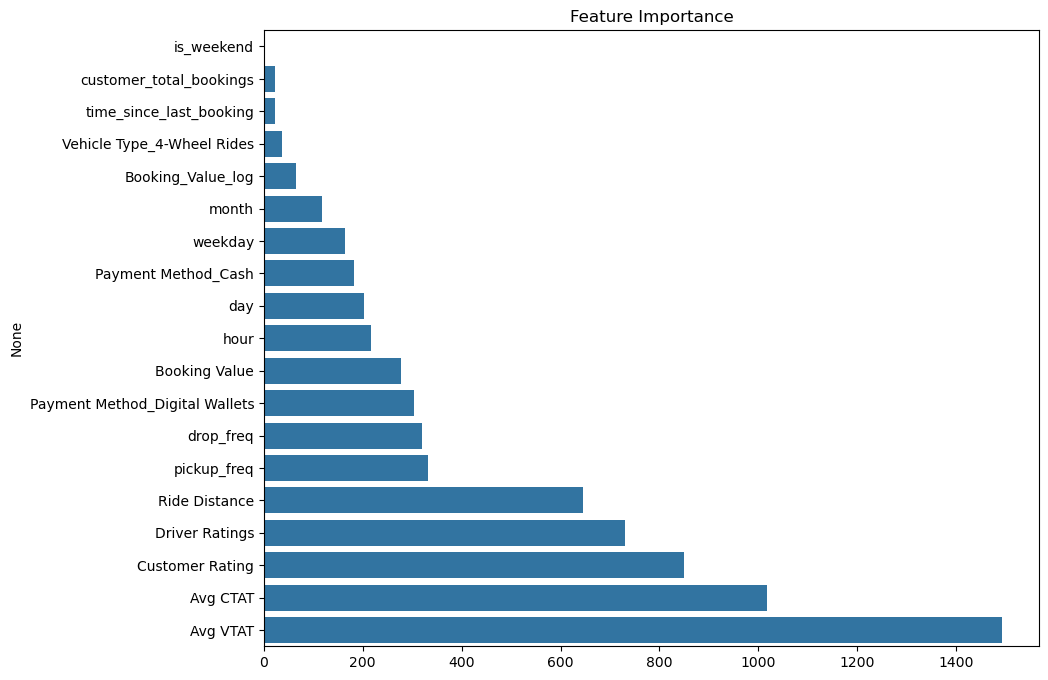

In [142]:
feature_importances = tuned_model_lgb.feature_importances_
sorted_idx = feature_importances.argsort()
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[sorted_idx], y=X.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()

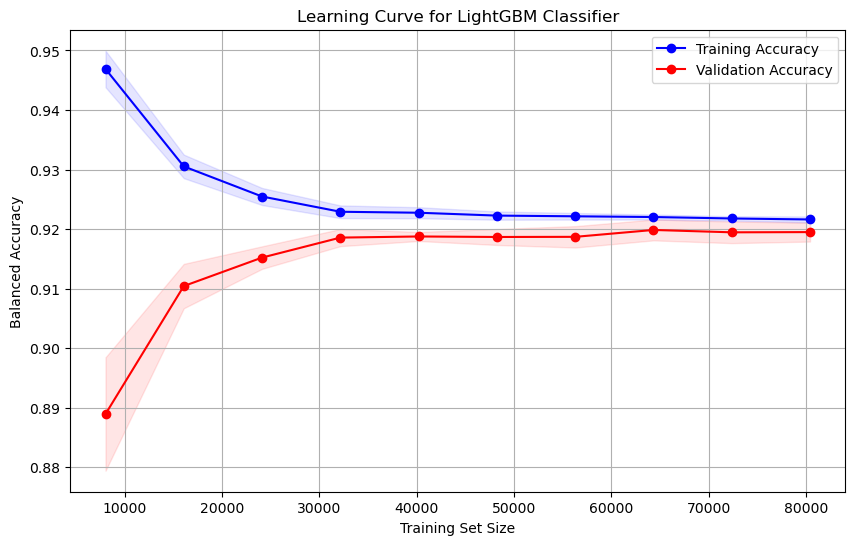

In [143]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    tuned_model_lgb, 
    x_train, 
    y_train, 
    cv=5, 
    scoring='balanced_accuracy',   # Imbalanced classes
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1,
    shuffle=True,
    random_state=100
)

# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.title('Learning Curve for LightGBM Classifier')
plt.xlabel('Training Set Size')
plt.ylabel('Balanced Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

#### As previously, depiction initiates with an acute overfit, due to a vast gap between training and validation lines. As we increment the training size, both lines align and stabilize pretty early displaying very good generalization performance overall.

#### **Optionally**, in order to mitigate the false positive, we may want to tune the decision threshold of our preference model. This can be done by manipulating precision-recall curve, finding the elbow point and set positive cases above this threshold.
#### But all these depend on our project objective, since each case drags it's own drawbacks to the ultimate result.

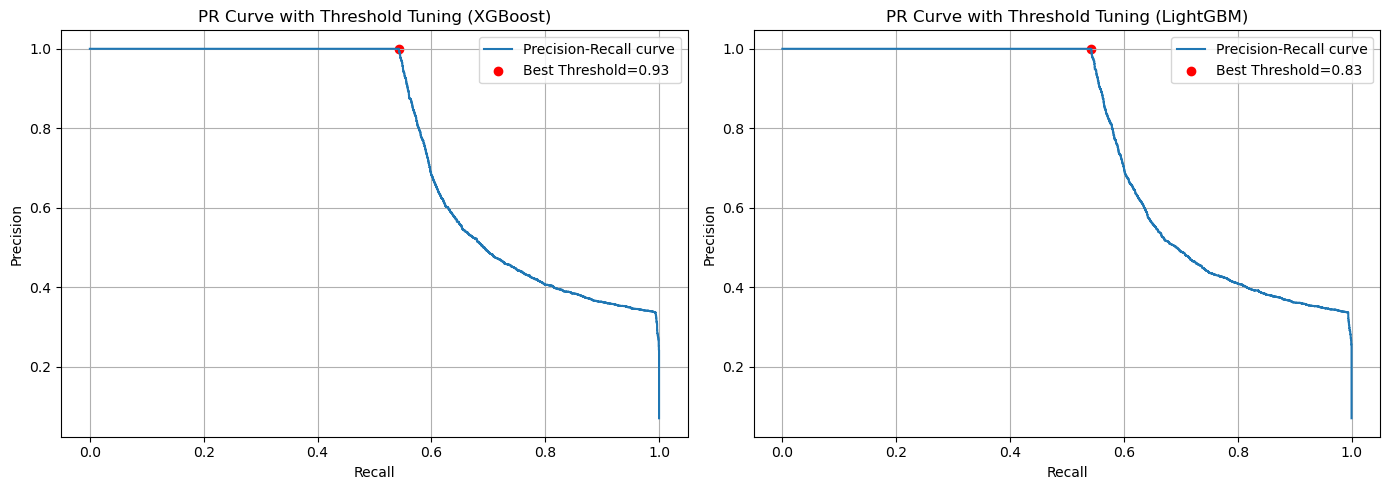

In [144]:
from sklearn.metrics import precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(14,5))  # 1 row, 2 columns

# --- XGBoost ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

axes[0].plot(recall, precision, label="Precision-Recall curve")
axes[0].scatter(recall[best_idx], precision[best_idx], color="red",
                label=f"Best Threshold={best_threshold:.2f}")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_title("PR Curve with Threshold Tuning (XGBoost)")
axes[0].legend()
axes[0].grid(True)

# --- LightGBM ---
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_lgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

axes[1].plot(recall, precision, label="Precision-Recall curve")
axes[1].scatter(recall[best_idx], precision[best_idx], color="red",
                label=f"Best Threshold={best_threshold:.2f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("PR Curve with Threshold Tuning (LightGBM)")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### Best threshold appears to be the elbow point at 0.96

In [145]:
# Apply custom threshold
y_pred_thres = (y_pred_proba >= 0.93).astype(int)

print(" Classification report with original threshold : ")
print(classification_report(y_test, y_pred))

print(" Classification report with custom threshold for XGBoost: ")
print(classification_report(y_test, y_pred_thres, digits=3))

 Classification report with original threshold : 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     46035
           1       0.34      0.99      0.50      3465

    accuracy                           0.86     49500
   macro avg       0.67      0.92      0.71     49500
weighted avg       0.95      0.86      0.89     49500

 Classification report with custom threshold for XGBoost: 
              precision    recall  f1-score   support

           0      0.967     1.000     0.983     46035
           1      1.000     0.543     0.703      3465

    accuracy                          0.968     49500
   macro avg      0.983     0.771     0.843     49500
weighted avg      0.969     0.968     0.964     49500



In [146]:
# Apply custom threshold
y_pred_thres_lgb = (y_pred_proba_lgb >= 0.83).astype(int)

print(" Classification report with original threshold : ")
print(classification_report(y_test, y_pred_lgb))

print(" Classification report with custom threshold for LightGBM : ")
print(classification_report(y_test, y_pred_thres_lgb, digits=3))

 Classification report with original threshold : 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     46035
           1       0.34      0.99      0.50      3465

    accuracy                           0.86     49500
   macro avg       0.67      0.92      0.71     49500
weighted avg       0.95      0.86      0.89     49500

 Classification report with custom threshold for LightGBM : 
              precision    recall  f1-score   support

           0      0.967     1.000     0.983     46035
           1      0.997     0.543     0.703      3465

    accuracy                          0.968     49500
   macro avg      0.982     0.771     0.843     49500
weighted avg      0.969     0.968     0.963     49500



# Uber Ride Cancellation Analysis Report

## 1. Dataset Overview

- **Size:** 150,000 ride bookings, 21 columns.  
- **Target:** Customer cancellations (~7% positive class → highly imbalanced).  
- **Key Features:** Ride distance, booking value, pickup/drop locations, ratings, payment method, vehicle type, datetime-derived variables.

---

## 2. Exploratory Data Analysis (EDA)

### Booking Status
- Most rides completed successfully.  
- Driver cancellations are the second most common reason.

### Vehicle Preference
- 4-wheel rides dominate (Go Sedan, Go Mini, UberXL).

### Temporal Trends
- Seasonal booking spikes observed (likely due to festivals/strikes).

### Cancellations
- **Driver cancellations:** Often linked to undesirable or long-distance trips.  
- **Customer cancellations:** More evenly distributed; “AC not working” is less significant.

### Ride Value & Distance
- **Fare distribution:** Right-skewed; most fares < 700 INR with some high-value outliers.  
- **Ride distance:** Normally distributed, average ~25 km.

### Ratings
- Customers and drivers generally rated >4.0, indicating high satisfaction.

### Payment Methods
- UPI most popular; cash remains significant.

---

## 3. Data Preparation & Feature Engineering

- **Time-based features:** Hour, day, weekday, weekend indicator.  
- **Vehicle type grouping:** 2/3-wheel vs 4-wheel.  
- **Payment grouping:** Cash, Digital Wallets, Cards.  
- **Customer behavior features:** Ride frequency and top 10 pickup/drop locations encoded.

### Handling Missing Data
- Median imputation for VTAT/CTAT.  
- XGBoost regressors for ratings, distance, and booking value (low RMSE, reliable imputations).  
- Log transformation applied to extreme booking values.

---

## 4. Modeling & Results

### Models
- **XGBoost Classifier**  
- **LightGBM**  
- Hyperparameter tuning via `RandomizedSearchCV`.

### Imbalance Handling
- `scale_pos_weight ≈ 13.29` for XGBoost; LightGBM handles imbalance natively.

### Base Results (Default Threshold)
| Model | Accuracy | ROC AUC | Class 0 Precision | Class 0 Recall | Class 0 F1 | Class 1 Precision | Class 1 Recall | Class 1 F1 |
|-------|---------|---------|-----------------|---------------|------------|-----------------|---------------|------------|
| XGBoost | 0.86 | 0.9646 | 1.00 | 0.85 | 0.92 | 0.33 | 0.99 | 0.50 |
| LightGBM | 0.86 | 0.9646 | 1.00 | 0.85 | 0.92 | 0.34 | 0.99 | 0.50 |

**Insights:**
- High recall for cancellations (excellent at catching positive cases).  
- Low precision → many false positives → unnecessary interventions.

### After Threshold Tuning (0.93  |  0.83)
| Model | Accuracy | Class 1 Precision | Class 1 Recall | Class 1 F1 |
|-------|---------|-----------------|---------------|------------|
| XGBoost | 0.97 | 1.00 | 0.54 | 0.70 |
| LightGBM | 0.968 | 1.00 | 0.54 | 0.70 |

**Insights:**
- Stronger balance between precision and recall.  
- Fewer false alarms but some true cancellations are missed.

### Conclusion
- Both models show similar performance metrics.  
- **LightGBM** is preferred for better generalization and is recommended for further analysis or deployment.
